In [1]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 
import statsmodels.api as sm 
import numpy as np 
import warnings 
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
# load dataset 
raw = pd.read_excel('Airlines+Data.xlsx',index_col=0,
                    header=0,parse_dates=True)
raw.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [3]:
# time series contains 96 observations 
# dtype of index is datetime 
print('dtype of index is : ',raw.index.dtype)
print('dataset shape : ',raw.shape)

dtype of index is :  datetime64[ns]
dataset shape :  (96, 1)


In [4]:
# no null values present 
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 1995-01-01 to 2002-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  96 non-null     int64
dtypes: int64(1)
memory usage: 1.5 KB


In [5]:
# splitting time series for training, validation and testing 
TRAIN , test = train_test_split(raw,test_size=0.2,shuffle=False) 
VALID, TEST = train_test_split(test,test_size=0.5,shuffle=False)
print('Training Data : ',TRAIN.shape)
print('Validation Data : ',VALID.shape)
print('Testing Data : ',TEST.shape)

Training Data :  (76, 1)
Validation Data :  (10, 1)
Testing Data :  (10, 1)


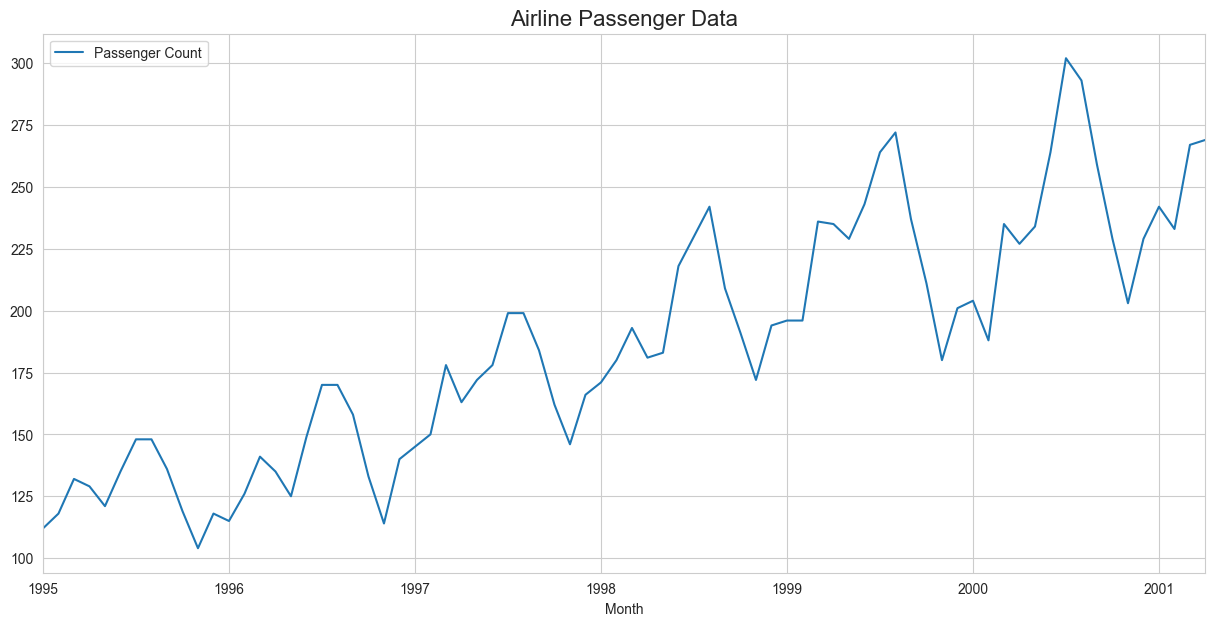

In [6]:
# visual analysis of TRAIN time series 
plt.figure(figsize=(15,7))
TRAIN.Passengers.plot(kind='line',label='Passenger Count')
plt.title('Airline Passenger Data',fontsize=16)
plt.legend()
plt.show()

In [7]:
hold = TRAIN.copy(deep=True)
hold['month'] = TRAIN.reset_index().Month.dt.month.values
hold['year'] = TRAIN.reset_index().Month.dt.year.values

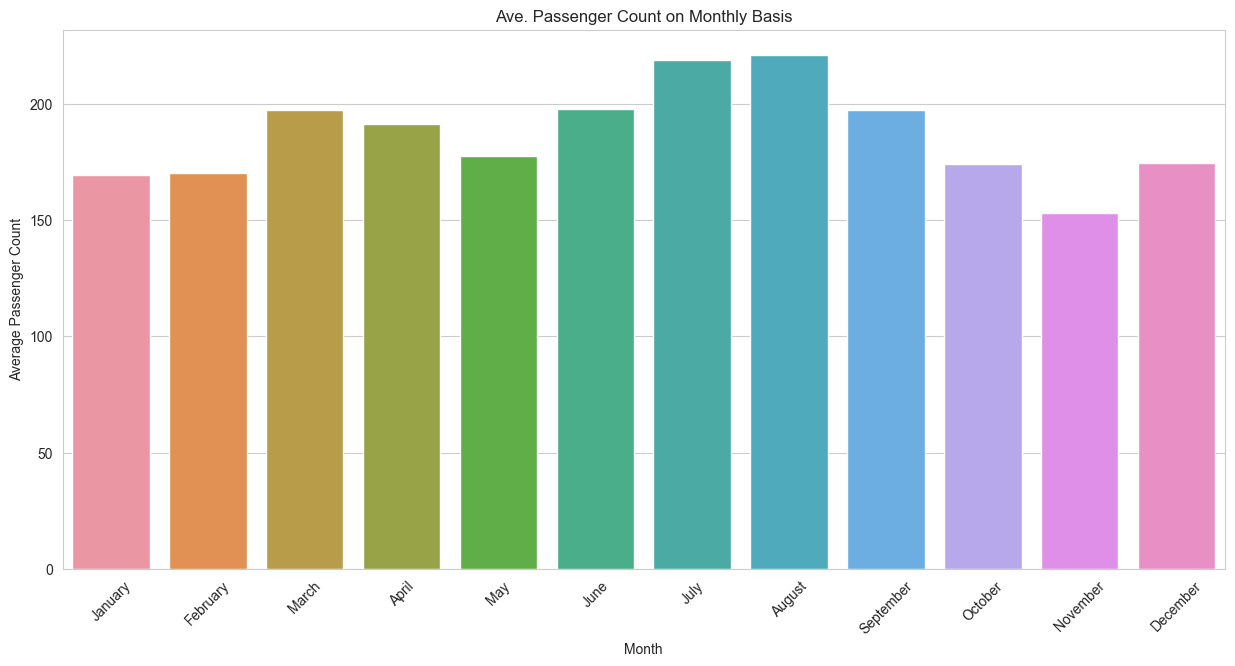

In [8]:
# Ave. passenger count is at pek in months of 'july' and 'august'
plt.figure(figsize=(15,7))
n = hold.groupby(by='month')['Passengers'].mean()
sns.barplot(x=hold.index.month_name().unique(),y=n.values)
plt.ylabel('Average Passenger Count')
plt.title('Ave. Passenger Count on Monthly Basis')
plt.xticks(rotation=45)
plt.show()

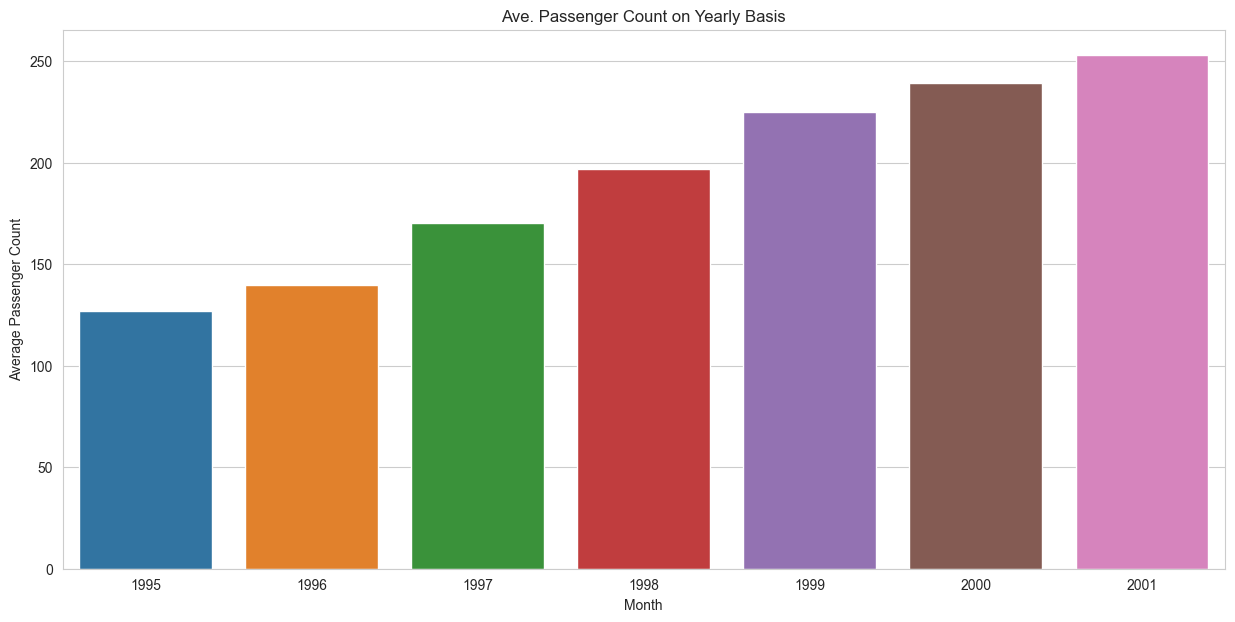

In [9]:
# Ave. passenger count has increased steadily over the years 
plt.figure(figsize=(15,7))
n = hold.groupby(by='year')['Passengers'].mean()
sns.barplot(x=hold.index.year.unique(),y=n.values)
plt.title('Ave. Passenger Count on Yearly Basis')
plt.ylabel('Average Passenger Count')
plt.show()

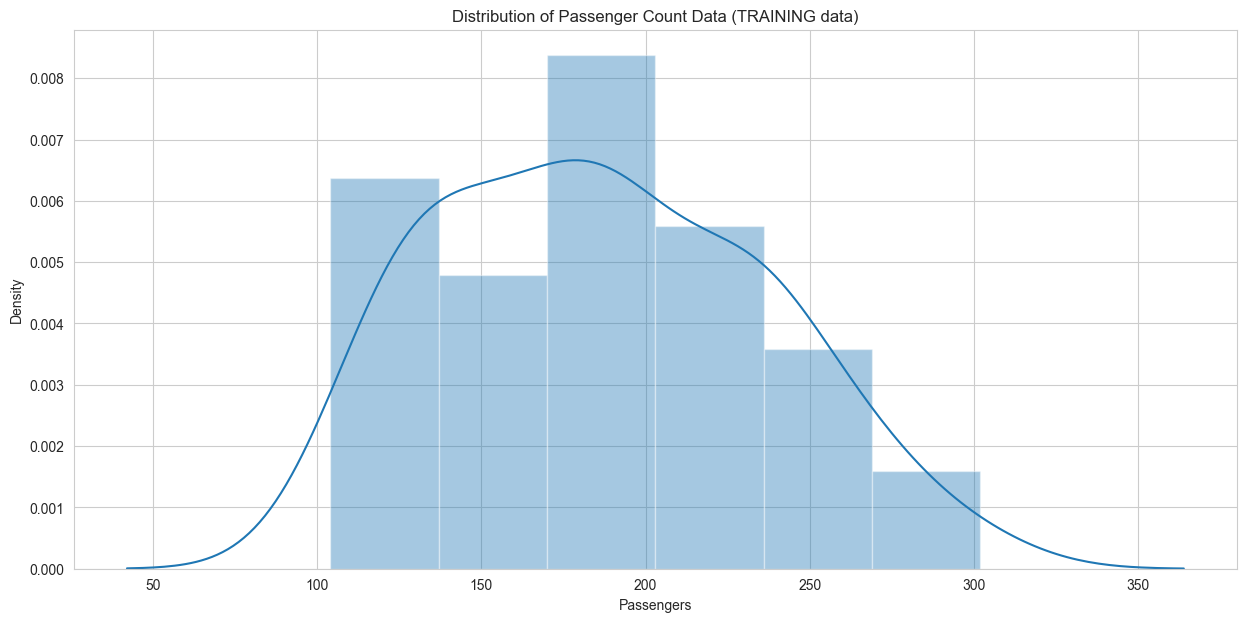

In [10]:
plt.figure(figsize=(15,7))
sns.distplot(TRAIN.Passengers)
plt.title('Distribution of Passenger Count Data (TRAINING data)')
plt.show()

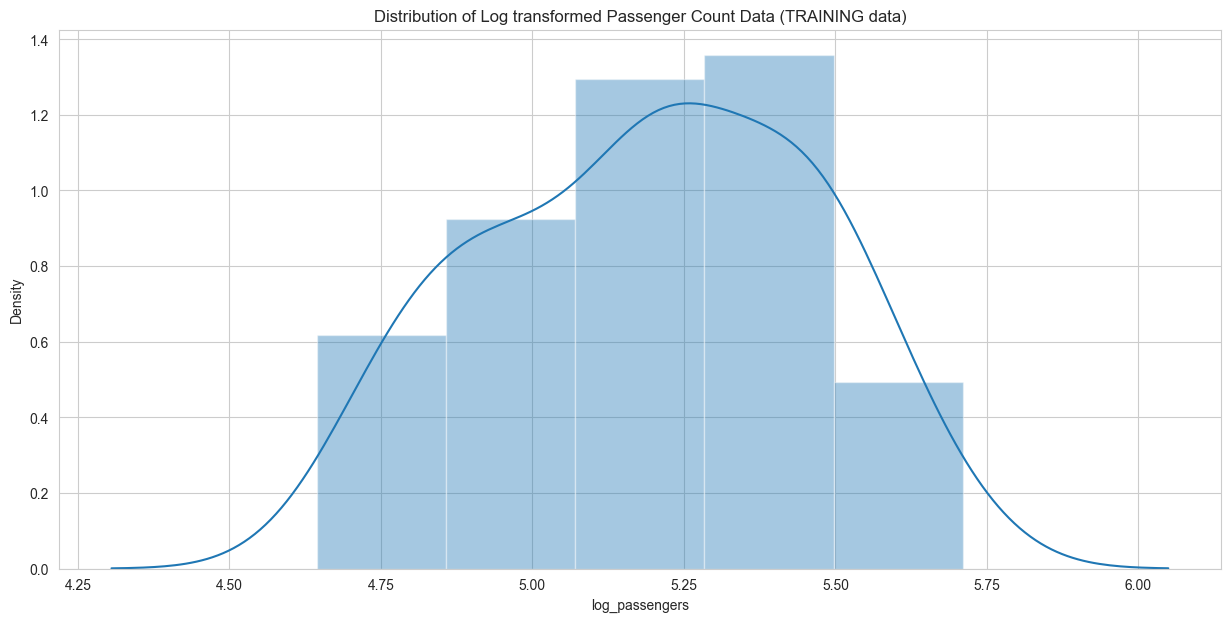

In [11]:
# Applying 'log' transformation on 'Passenger' data
# to emliminate multiplicative component 
TRAIN['log_passengers'] = np.log(TRAIN.Passengers).values
# After 'log' transformation 
plt.figure(figsize=(15,7))
sns.distplot(TRAIN.log_passengers)
plt.title('Distribution of Log transformed Passenger Count Data (TRAINING data)')
plt.show()

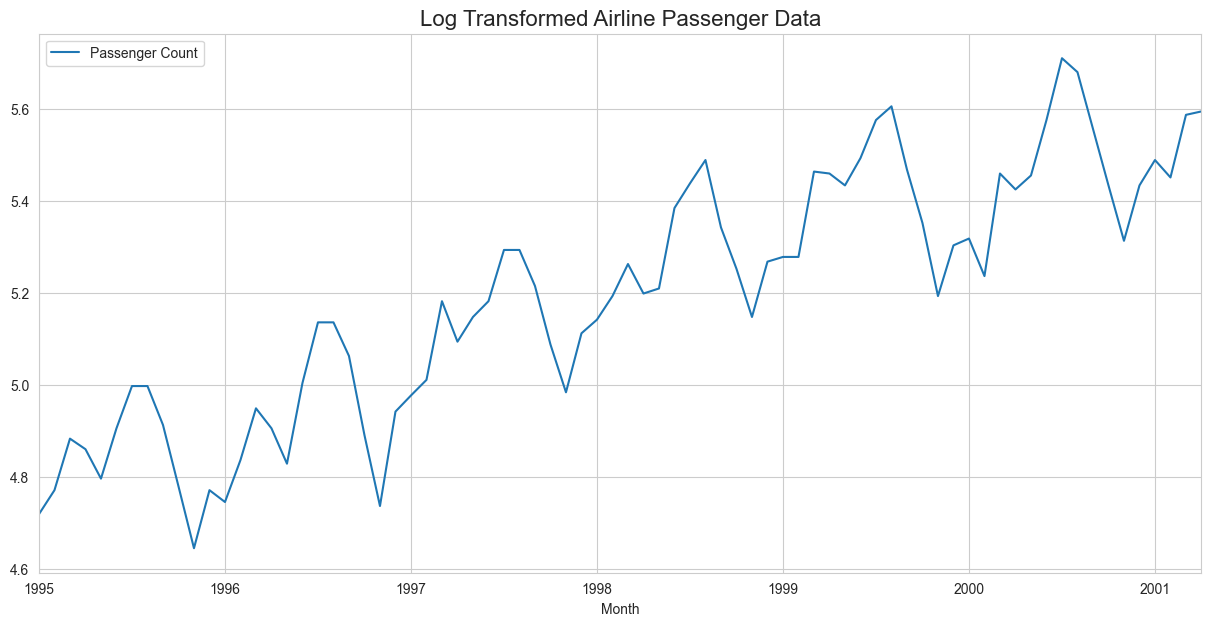

In [12]:
# visual analysis of log transformed time series 
plt.figure(figsize=(15,7))
TRAIN.log_passengers.plot(kind='line',label='Passenger Count')
plt.title('Log Transformed Airline Passenger Data',fontsize=16)
plt.legend()
plt.show()

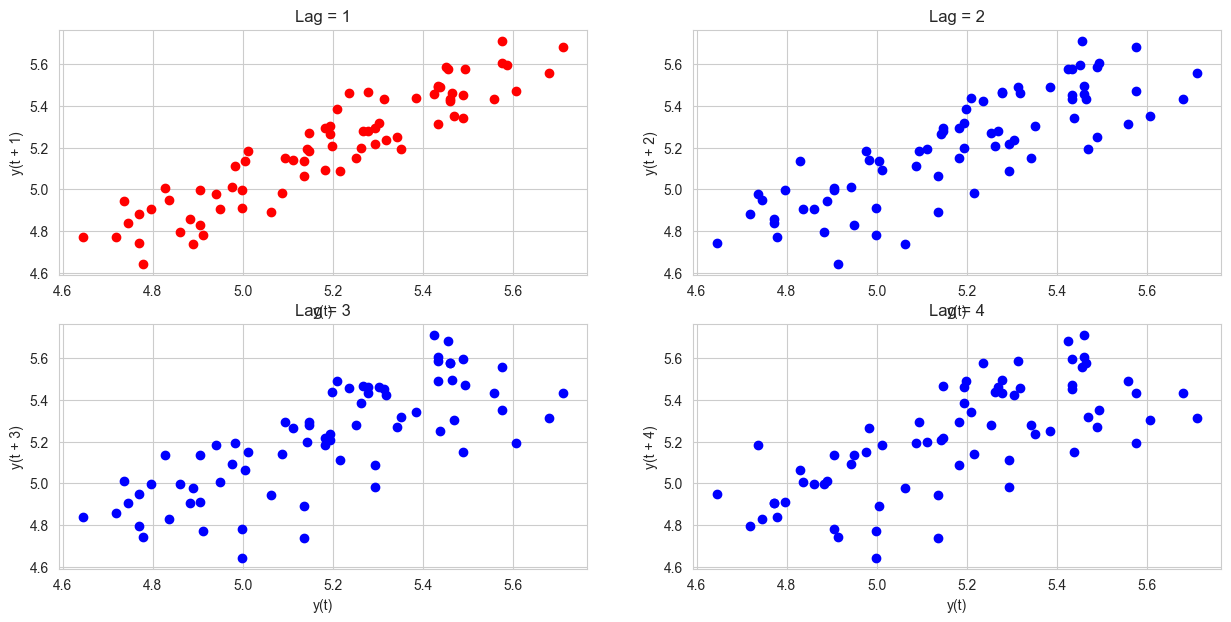

In [13]:
# lag plots of 'log transformed passengers count'
# There exists autocorrelation 
# Auto regression can be applied
plt.figure(figsize=(15,7))
for k in range(1,5):
    plt.subplot(2,2,k)
    if k == 1:
        color = 'red'
    else :
        color = 'blue'
    pd.plotting.lag_plot(TRAIN.log_passengers,lag=k,c=color)
    plt.title(f'Lag = {k}')
plt.show()

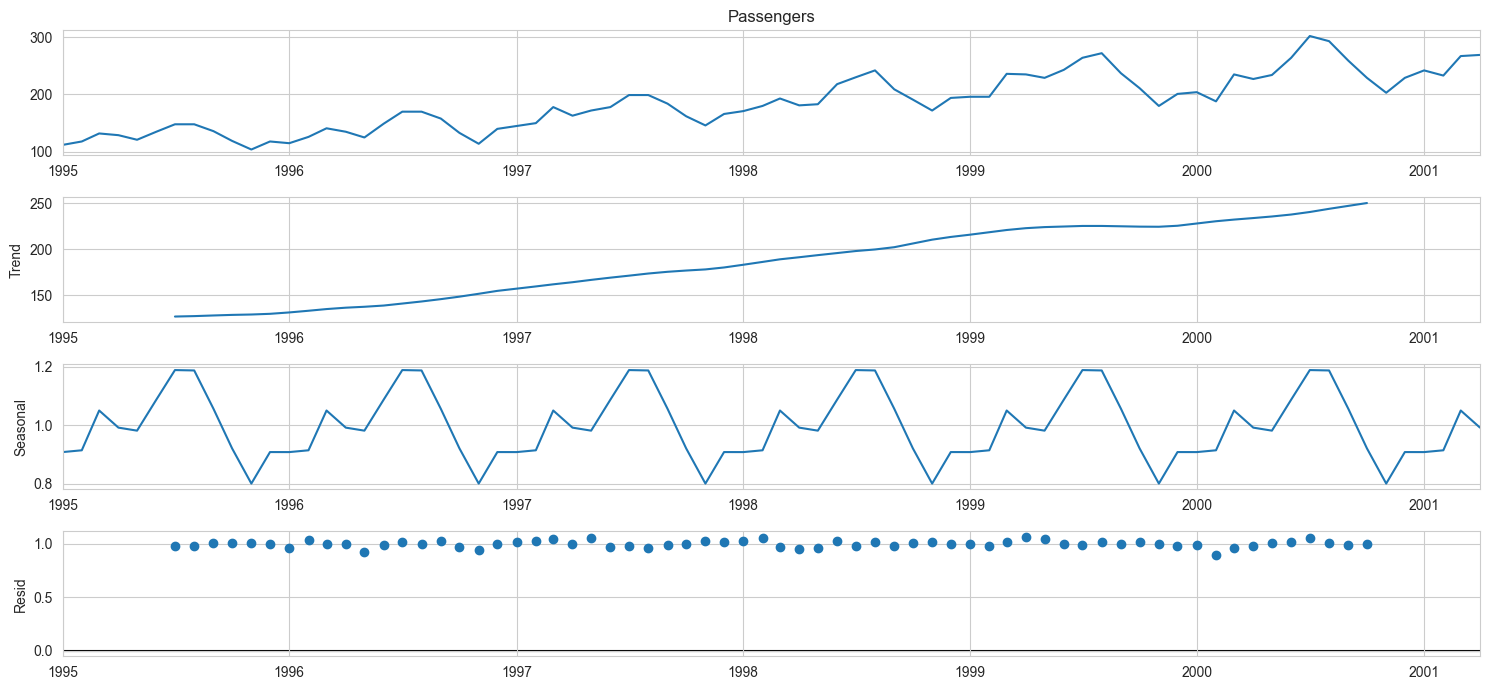

In [14]:
res = seasonal_decompose(TRAIN.Passengers,model='multiplicative').plot()
res.set_size_inches((15,7))
res.tight_layout()
plt.show()

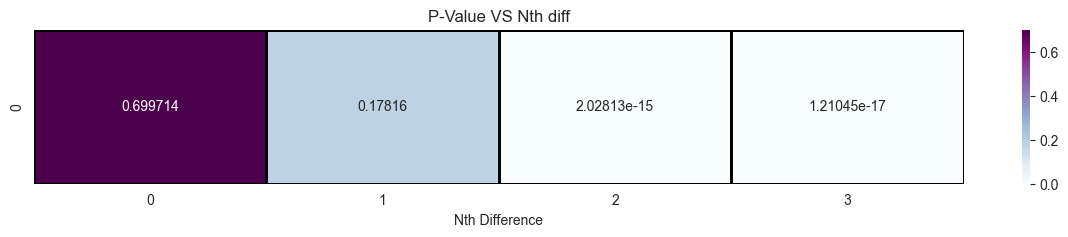

In [15]:
p_values = []
for i in range(4):
    if i > 0:
        emp = TRAIN.log_passengers.values.ravel()
        for j in range(i):
            emp = emp[1:]-emp[:-1]
        p_values.append(adfuller(emp)[1])
    else :
        p_values.append(adfuller(TRAIN.log_passengers.values.ravel())[1])
# 2nd order differencing makes time series stationary 
# becoz p_values < 0.05
# choosing value of 'I' as 2
plt.figure(figsize=(15,2))
sns.heatmap([p_values],
            linewidth=1,linecolor='black',
            cmap='BuPu',annot=True,fmt='g')
plt.xlabel('Nth Difference')
plt.title('P-Value VS Nth diff')
plt.show()

In [16]:
def RMSE(actual,predicted):
    rmse = np.square(np.subtract(actual.values.ravel(),
                                 predicted.values.ravel())).mean()
    return rmse

## NAIVE model

In [17]:
NaiveModel = ExponentialSmoothing(TRAIN.Passengers).fit()

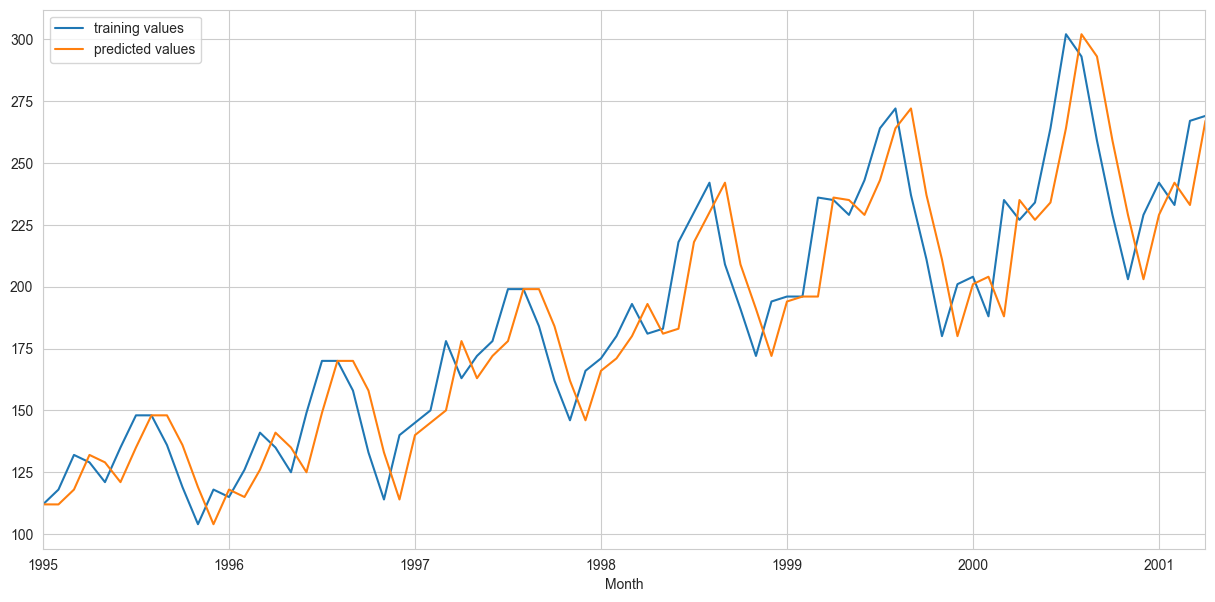

In [18]:
# forecasting on training data
plt.figure(figsize=(15,7))
TRAIN.Passengers.plot(label='training values')
NaiveModel.predict(start=0).plot(label='predicted values')
plt.legend()
plt.show()

In [19]:
print(f'TRAINING RMSE : {round(RMSE(TRAIN.Passengers,NaiveModel.predict(start=0))*100,4)} %')

TRAINING RMSE : 36169.7656 %


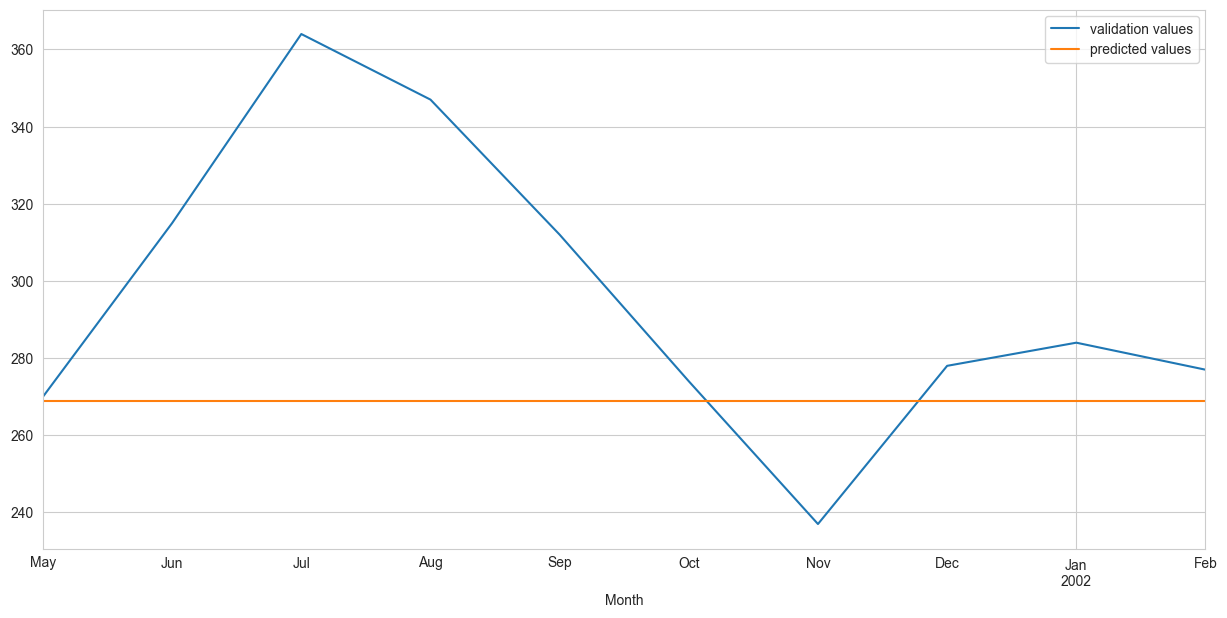

In [20]:
# forecasting on validation data
plt.figure(figsize=(15,7))
VALID.Passengers.plot(label='validation values')
NaiveModel.forecast(10).plot(label='predicted values')
plt.legend()
plt.show()

In [21]:
print(f'VALIDATION RMSE : {round(RMSE(VALID.Passengers,NaiveModel.forecast(10))*100,4)} %')

VALIDATION RMSE : 204940.0253 %


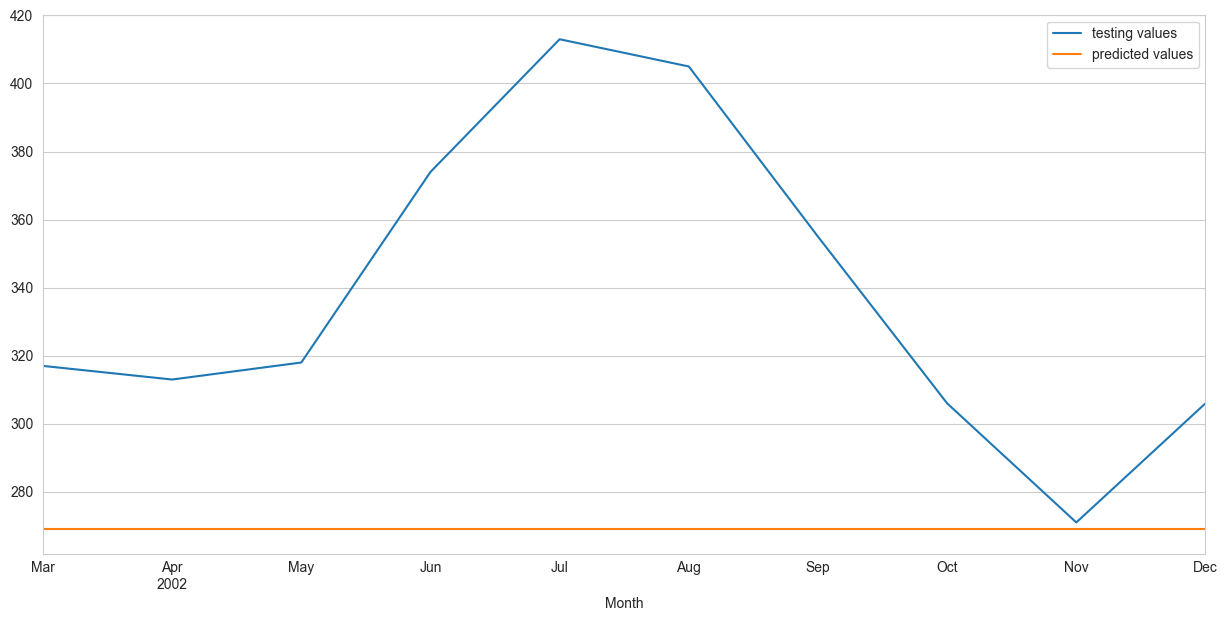

In [22]:
# forecasting on testing data 
plt.figure(figsize=(15,7))
TEST.Passengers.plot(label='testing values')
NaiveModel.forecast(20)[10:].plot(label='predicted values')
plt.legend()
plt.show()

In [23]:
print(f'TESTING RMSE : {round(RMSE(TEST.Passengers,NaiveModel.forecast(20)[10:])*100,4)} %')

TESTING RMSE : 670360.0651 %


In [24]:
pd.DataFrame([['TRAINING',36169.7656],
              ['VALIDATION',204940.0253],
              ['TESTING',670360.0651]],columns=['NAIVE','% RMSE'])

,NAIVE,% RMSE
0,TRAINING,36169.7656
1,VALIDATION,204940.0253
2,TESTING,670360.0651


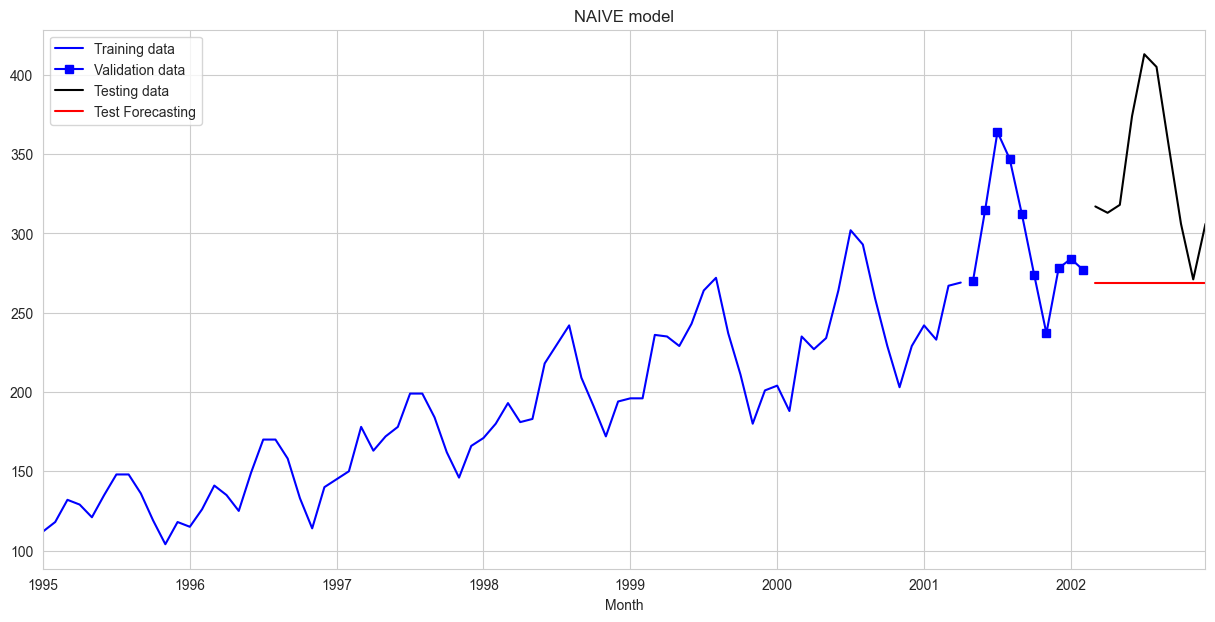

In [25]:
plt.figure(figsize=(15,7))
TRAIN.Passengers.plot(color='blue',label='Training data')
VALID.Passengers.plot(style='bs-',label='Validation data')
TEST.Passengers.plot(color='black',label='Testing data')
NaiveModel.forecast(20)[10:].plot(color='red',
                                  label='Test Forecasting')
plt.legend()
plt.title('NAIVE model')
plt.show()

## ARIMA model

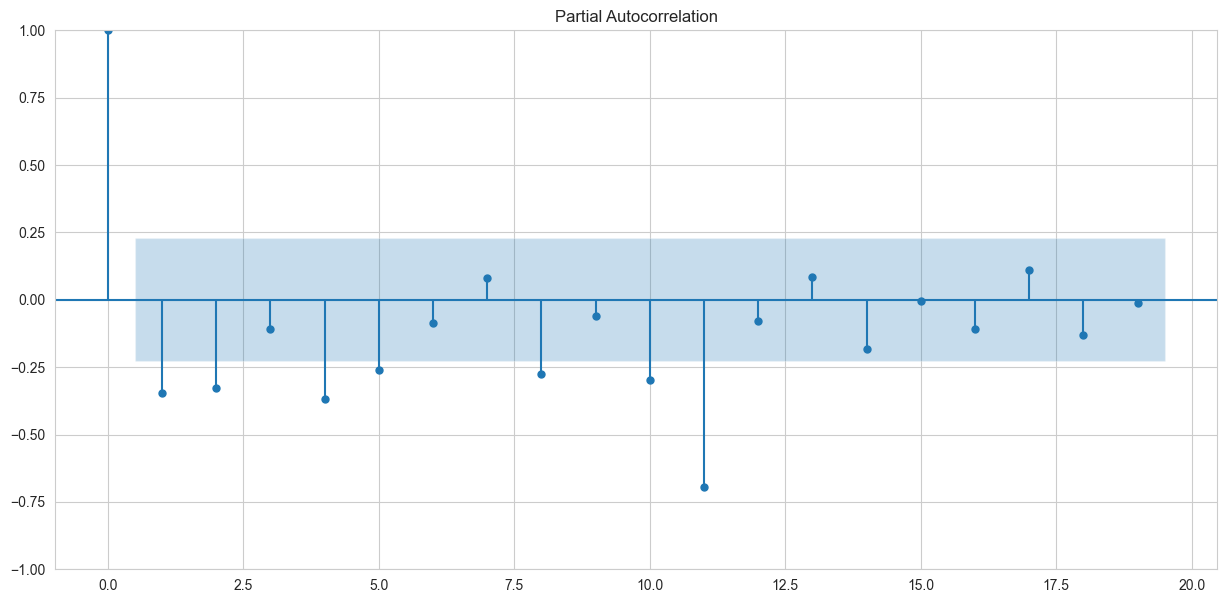

In [26]:
I = 2
emp = TRAIN.log_passengers.values.ravel()
for i in range(I):
    emp = emp[1:]-emp[:-1]
res = plot_pacf(emp,method='ywm')
res.set_size_inches((15,7))
plt.show()
# get 'P' values from pacf graph
P = [1,2,4,5,8,10,11]

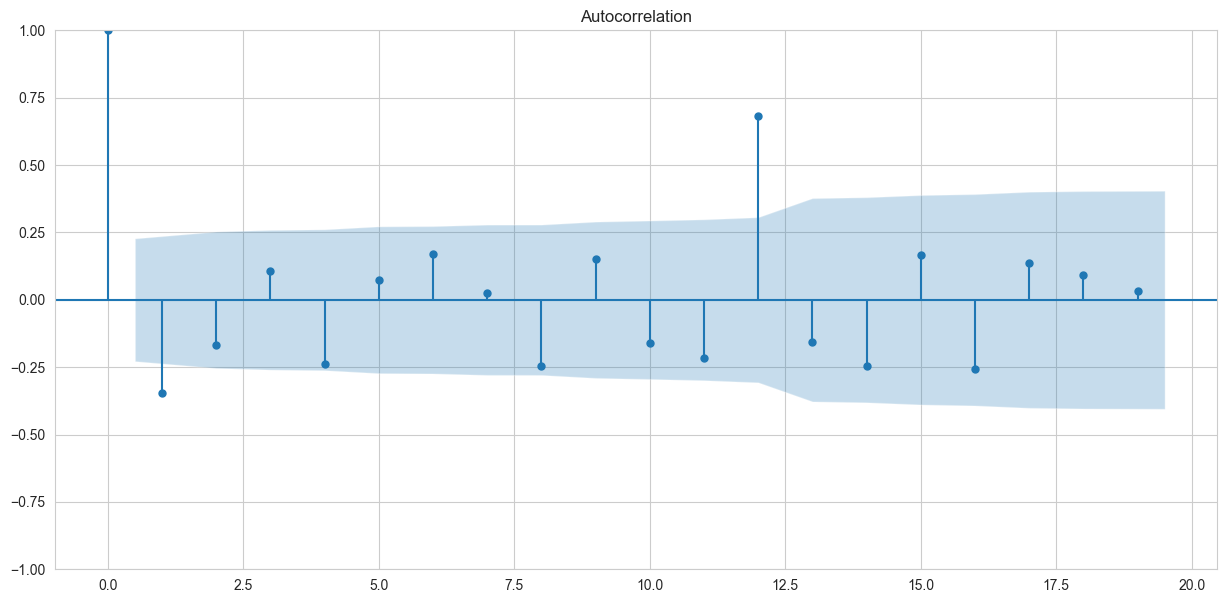

In [27]:
res = plot_acf(emp)
res.set_size_inches((15,7))
plt.show()
# get 'Q' values from acf graph
Q = [1,12]

In [28]:
print('Possible -> ')
print('Order for AR model : ',P)
print('Order for differencing : ',I)
print('Order for MA model : ',Q)

Possible -> 
Order for AR model :  [1, 2, 4, 5, 8, 10, 11]
Order for differencing :  2
Order for MA model :  [1, 12]


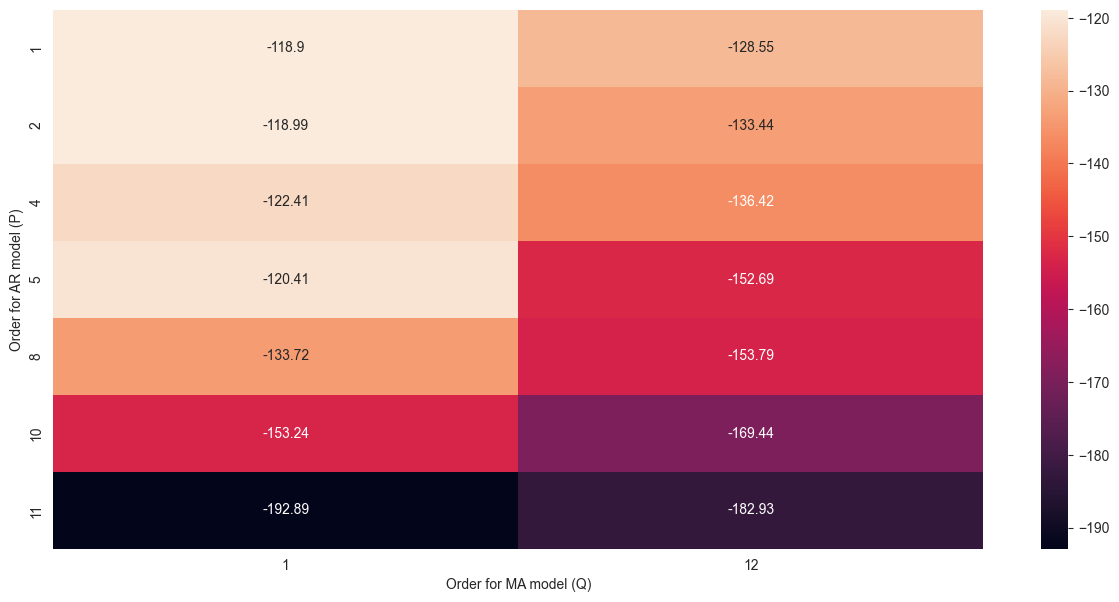

In [29]:
# Performing Grid Search over possible P,I,Q values
hold = []
for x in P:
    emp = []
    for y in Q:
        emp.append(round(ARIMA(TRAIN.log_passengers,
                               order=(x,I,y)).fit().aic,2))
    hold.append(emp)
# grid search give lowest AIC value of -192.89
# at p = 11 and Q = 1
plt.figure(figsize=(15,7))
sns.heatmap(hold,annot=True,fmt='g',
            yticklabels=P,xticklabels=Q)
plt.xlabel('Order for MA model (Q)')
plt.ylabel('Order for AR model (P)')
plt.show()

In [30]:
order = (11,2,1)
print('Order of ARIMA : ',order)

Order of ARIMA :  (11, 2, 1)


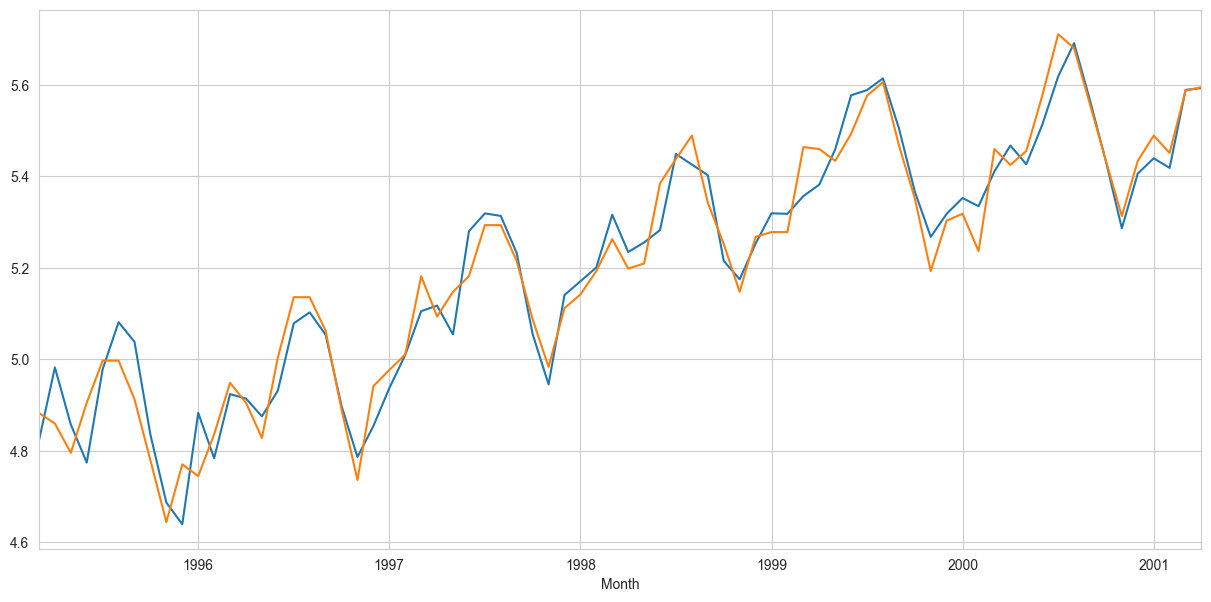

In [31]:
# forecasting on Training data
plt.figure(figsize=(15,7))
ArimaModel = ARIMA(TRAIN.log_passengers,order=order).fit()
ArimaModel.predict()[I:].plot()
TRAIN.log_passengers[I:].plot()
plt.show()

In [32]:
print(f'TRAINING RMSE : {round(RMSE(TRAIN.log_passengers[I:],ArimaModel.predict()[I:])*100,4)} %')

TRAINING RMSE : 0.3483 %


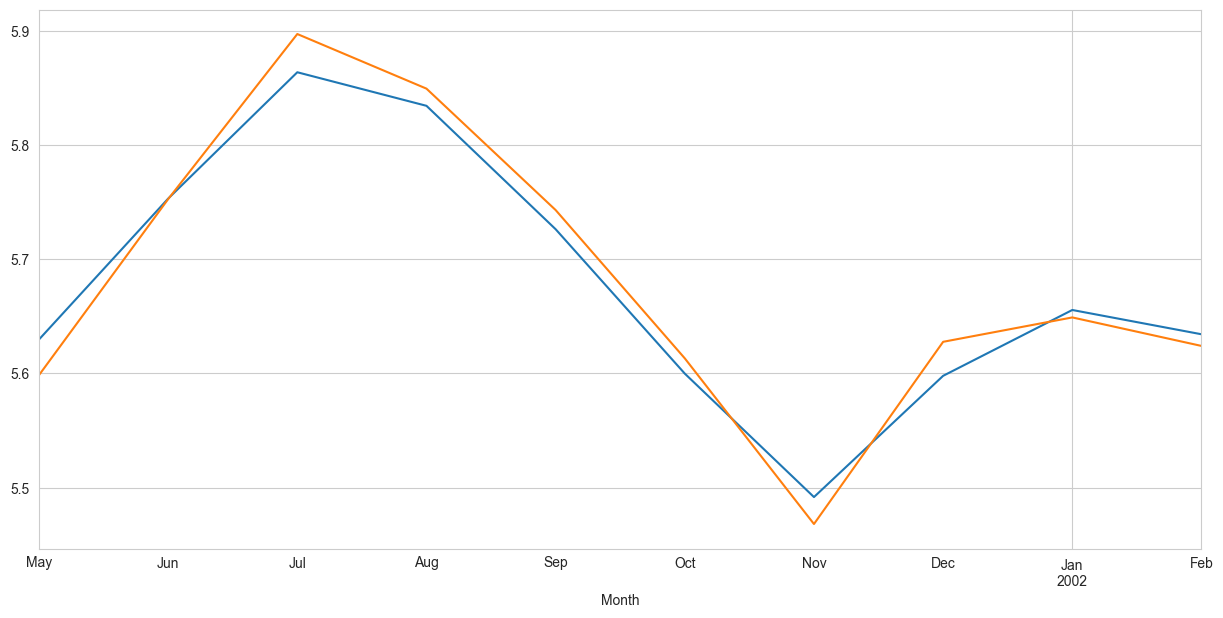

In [33]:
# forecasting on Validation data 
plt.figure(figsize=(15,7))
ArimaModel.forecast(10).plot()
np.log(VALID.Passengers).plot()
plt.show()

In [34]:
print(f'VALIDATION RMSE : {round(RMSE(np.log(VALID.Passengers),ArimaModel.forecast(10))*100,4)} %')

VALIDATION RMSE : 0.0437 %


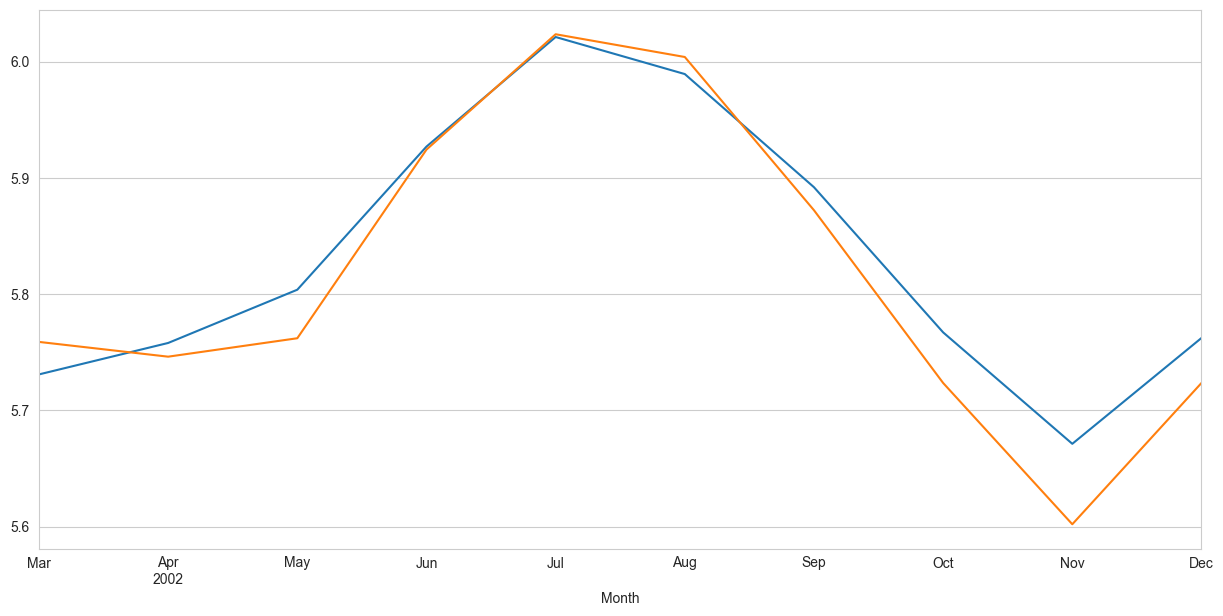

In [35]:
# forecasting on Testing data
plt.figure(figsize=(15,7))
ArimaModel.forecast(20)[10:].plot()
np.log(TEST.Passengers).plot()
plt.show()

In [36]:
print(f'TESTING RMSE : {round(RMSE(np.log(TEST.Passengers),ArimaModel.forecast(20)[10:])*100,4)} %')

TESTING RMSE : 0.1145 %


In [37]:
pd.DataFrame([['TRAINING',0.3483],
              ['VALIDATION',0.0437],
              ['TESTING',0.1145]],columns=['ARIMA','% RMSE'])

,ARIMA,% RMSE
0,TRAINING,0.3483
1,VALIDATION,0.0437
2,TESTING,0.1145


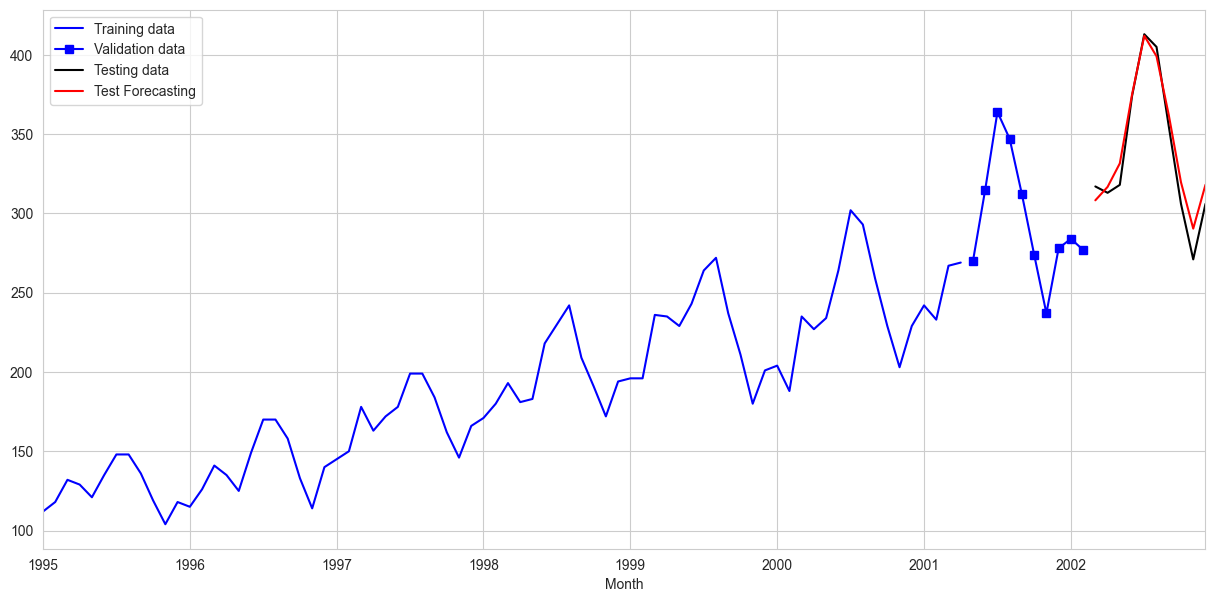

In [38]:
plt.figure(figsize=(15,7))
TRAIN.Passengers.plot(color='blue',label='Training data')
VALID.Passengers.plot(style='bs-',label='Validation data')
TEST.Passengers.plot(color='black',label='Testing data')
(np.e**(ArimaModel.forecast(20)[10:])).plot(color='red',
                                            label='Test Forecasting')
plt.legend()
plt.show()

## SARIMA model

In [44]:
# seasonal difference of 12 periods
samp = TRAIN.copy(deep=True)
samp = TRAIN.diff(12).dropna()
M = 12

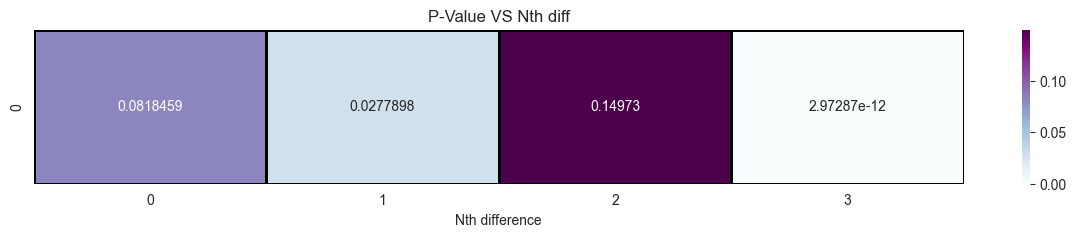

In [45]:
p_values = []
for i in range(4):
    if i > 0:
        emp = samp.log_passengers.values.ravel()
        for j in range(i):
            emp = emp[1:]-emp[:-1]
        p_values.append(adfuller(emp)[1])
    else :
        p_values.append(adfuller(samp.log_passengers.values.ravel())[1])
# 3rd order differencing makes time series stationary 
# becoz p_value < 0.05
# choosing value of 'Is' as 3
plt.figure(figsize=(15,2))
sns.heatmap([p_values],
            linewidth=1,linecolor='black',
            cmap='BuPu',annot=True,fmt='g')
plt.xlabel('Nth difference')
plt.title('P-Value VS Nth diff')
plt.show()

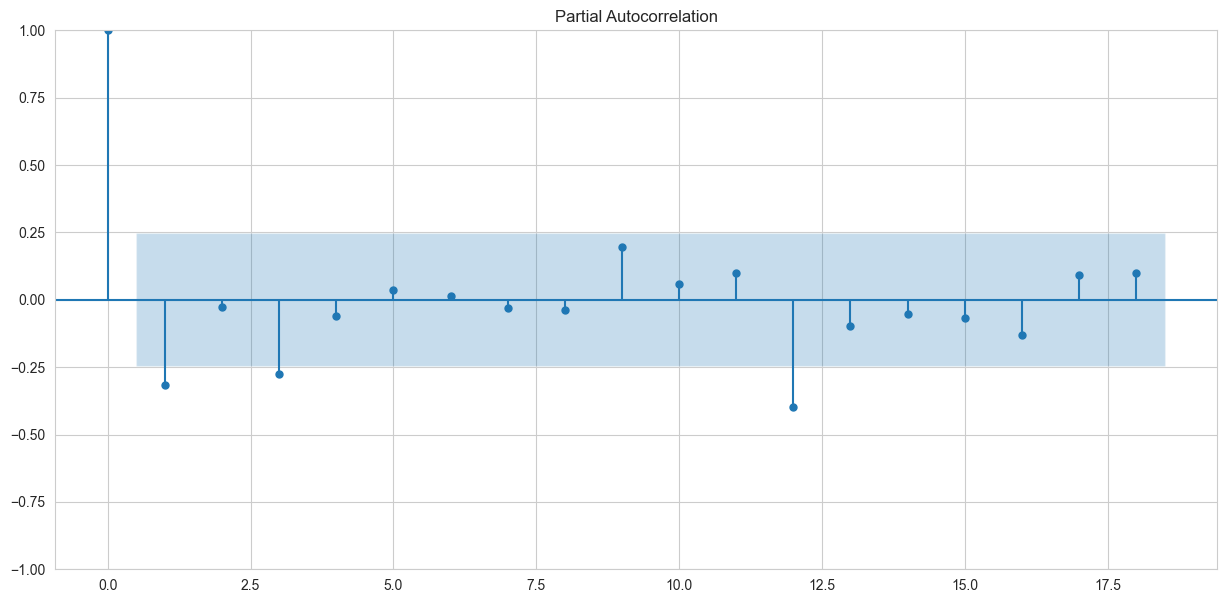

In [46]:
Is = 1
emp = samp.log_passengers.values.ravel()
for i in range(Is):
    emp = emp[1:]-emp[:-1]
res = plot_pacf(emp,method='ywm')
res.set_size_inches((15,7))
plt.show()
# get 'Ps' values from pacf graph
Ps = [1,3,12]

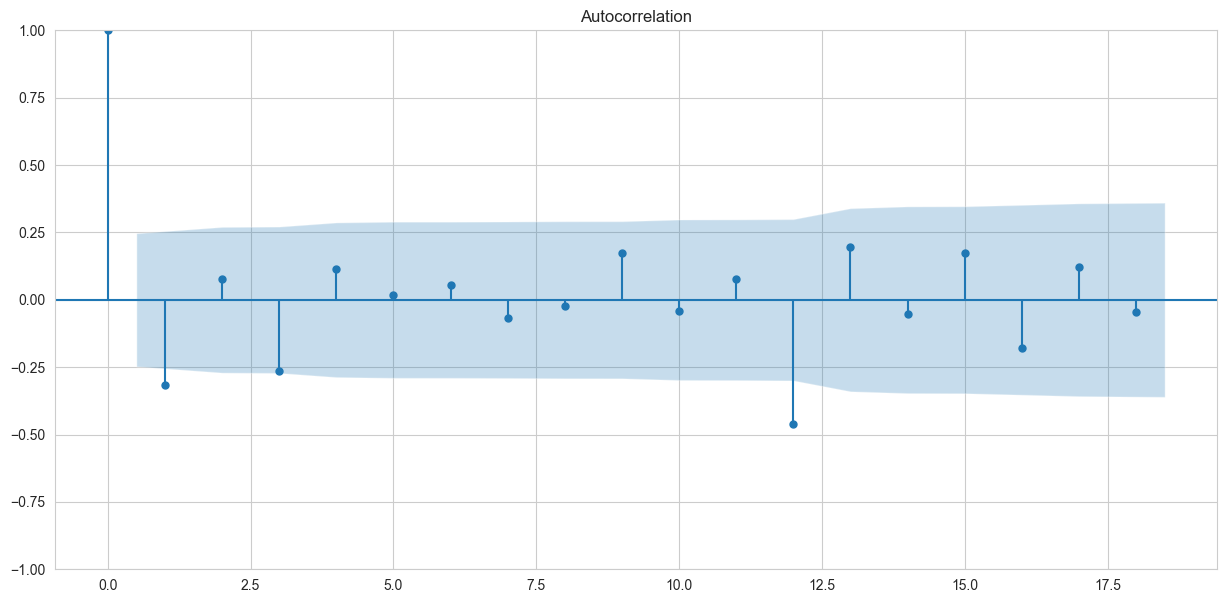

In [47]:
res = plot_acf(emp)
res.set_size_inches((15,7))
plt.show()
# get 'Qs' values from acf graph
Qs = [1,12]

In [48]:
print('Possible -> ')
print('Seasonal order for AR model : ',Ps)
print('Seasonal order for differencing : ',Is)
print('Seasonal order for MA model : ',Qs)
print('Seasonal order for seasonal differncing : ',M)

Possible -> 
Seasonal order for AR model :  [1, 3, 12]
Seasonal order for differencing :  1
Seasonal order for MA model :  [1, 12]
Seasonal order for seasonal differncing :  12


Completed : 16.666666666666668 %
Completed : 33.333333333333336 %
Completed : 50.0 %
Completed : 66.66666666666667 %
Completed : 83.33333333333333 %
Completed : 100.0 %


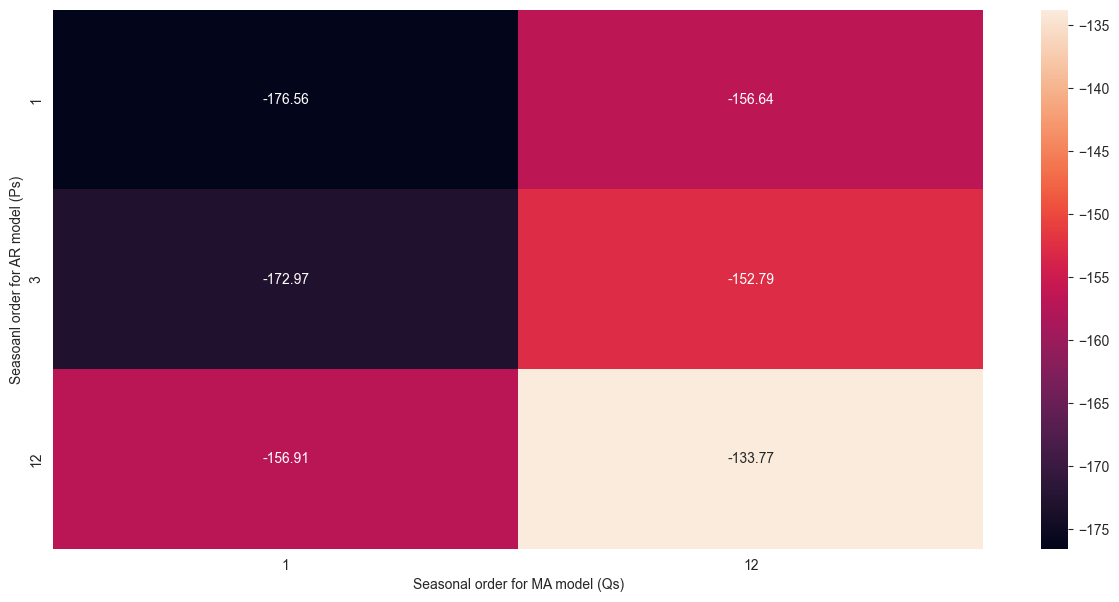

In [50]:
# Performing Grid Search over possible Ps, Is, Qs, M values
hold = []
count = 1
for x in Ps:
    emp = []
    for y in Qs:
        emp.append(round(SARIMAX(TRAIN.log_passengers,
                                 order=order,
                                 seasonal_order=(x,Is,y,M)).fit().aic,2))
        print(f'Completed : {count*100/6} %')
        count += 1
    hold.append(emp)
# grid search give lowest AIC value of  -176.56
# at Ps = 1 and Qs = 1
plt.figure(figsize=(15,7))
sns.heatmap(hold,annot=True,fmt='g',
            yticklabels=Ps,xticklabels=Qs)
plt.xlabel('Seasonal order for MA model (Qs)')
plt.ylabel('Seasoanl order for AR model (Ps)')
plt.show()

In [67]:
seasonal_order = (1,1,1,12)
print('Order of ARIMA : ',order)
print('Seasonal order of SARIMA : ',seasonal_order)

Order of ARIMA :  (11, 2, 1)
Seasonal order of SARIMA :  (1, 1, 1, 12)


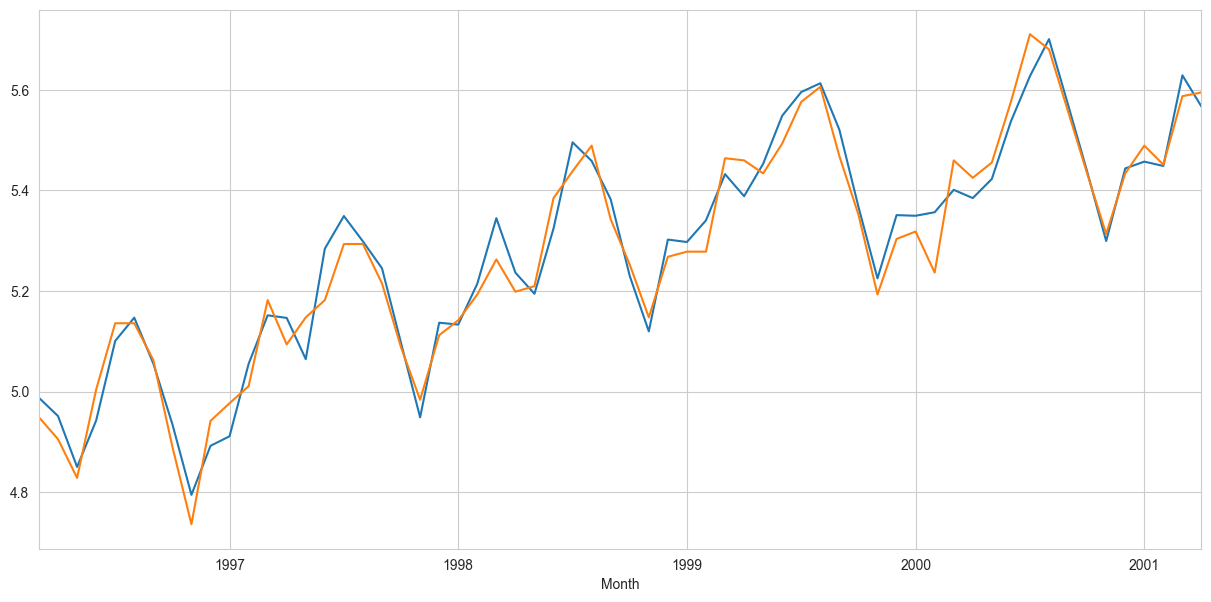

In [56]:
# forecasting on Training data 
plt.figure(figsize=(15,7))
SarimaModel = SARIMAX(TRAIN.log_passengers,order=order,
                      seasonal_order=seasonal_order).fit()
SarimaModel.predict()[2+M:].plot()
TRAIN.log_passengers[2+M:].plot()
plt.show()

In [69]:
print(f'TRAINING RMSE : {round(RMSE(TRAIN.log_passengers[2+M:],SarimaModel.predict()[2+M:])*100,4)} %')

TRAINING RMSE : 0.2034 %


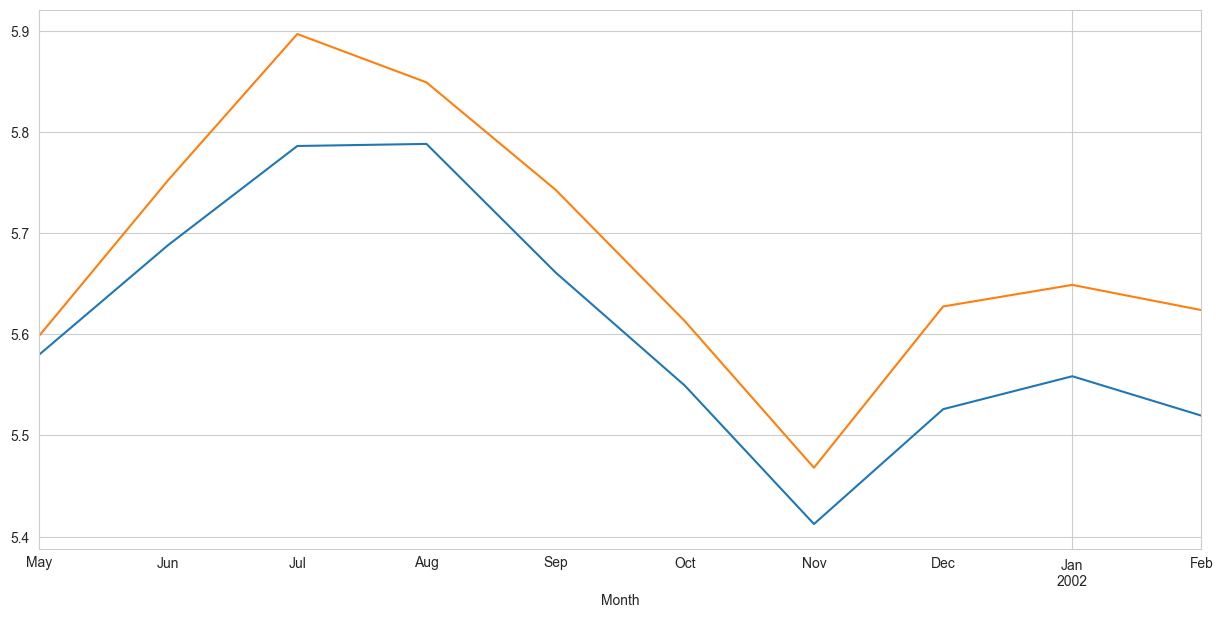

In [60]:
# forecasting on validation data 
plt.figure(figsize=(15,7))
SarimaModel.forecast(10).plot()
np.log(VALID.Passengers).plot()
plt.show()

In [61]:
print(f'VALIDATION RMSE : {round(RMSE(np.log(VALID.Passengers),SarimaModel.forecast(10))*100,4)} %')

VALIDATION RMSE : 0.6371 %


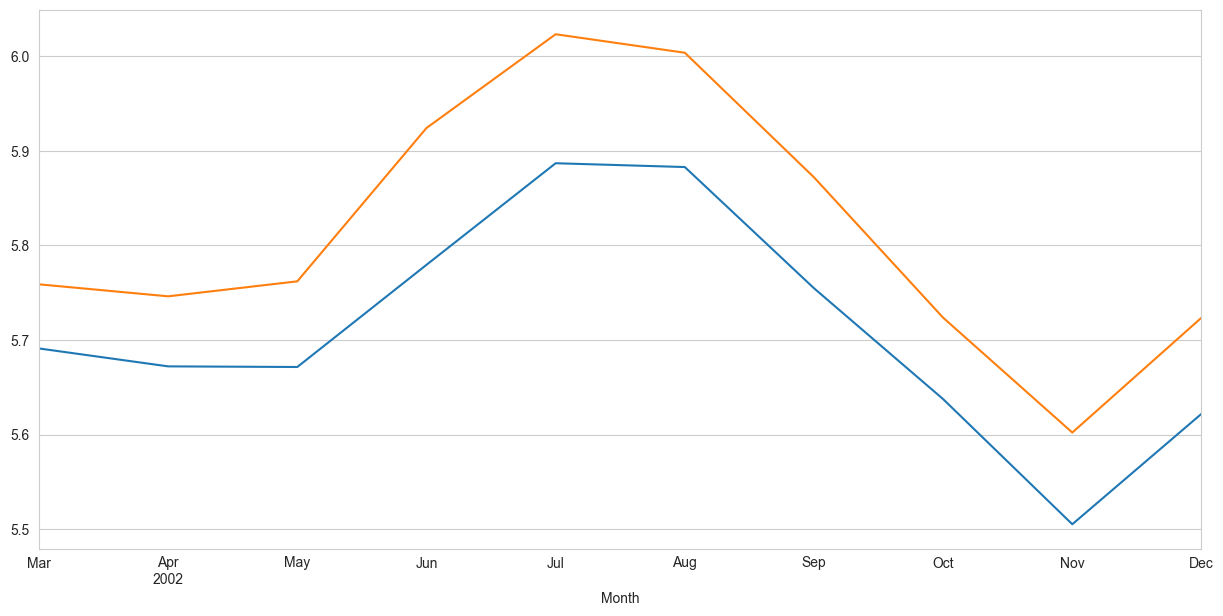

In [63]:
# forecasting on Testing data 
plt.figure(figsize=(15,7))
SarimaModel.forecast(20)[10:].plot()
np.log(TEST.Passengers).plot()
plt.show()

In [64]:
print(f'TESTING RMSE : {round(RMSE(np.log(TEST.Passengers),SarimaModel.forecast(20)[10:])*100,4)} %')

TESTING RMSE : 1.1344 %


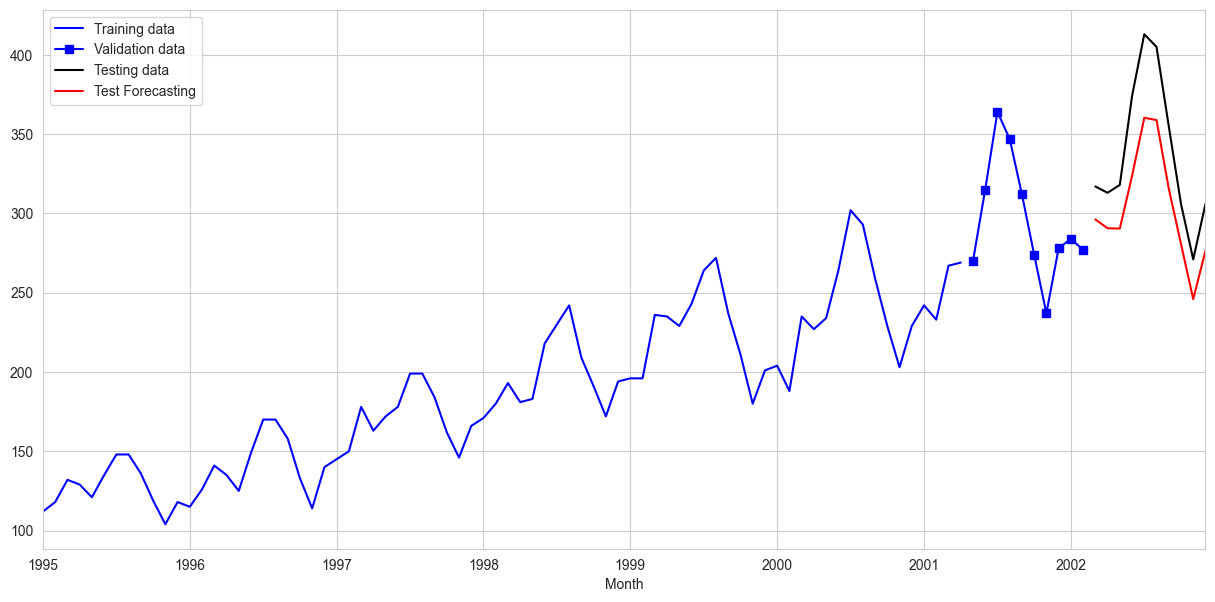

In [65]:
plt.figure(figsize=(15,7))
TRAIN.Passengers.plot(color='blue',label='Training data')
VALID.Passengers.plot(style='bs-',label='Validation data')
TEST.Passengers.plot(color='black',label='Testing data')
(np.e**(SarimaModel.forecast(20)[10:])).plot(color='red',
                                             label='Test Forecasting')
plt.legend()
plt.show()

In [72]:
pd.DataFrame([['TRAINING',0.2034],
              ['VALIDATION',0.6371],
              ['TESTING',1.1344]],columns=['SARIMA','% RMSE'])

,SARIMA,% RMSE
0,TRAINING,0.2034
1,VALIDATION,0.6371
2,TESTING,1.1344


## HOLT-WINTERS smoothing 

In [75]:
HoltWintModel = ExponentialSmoothing(TRAIN.Passengers,
                                     trend='add',
                                     seasonal='mul',
                                     seasonal_periods=12).fit()

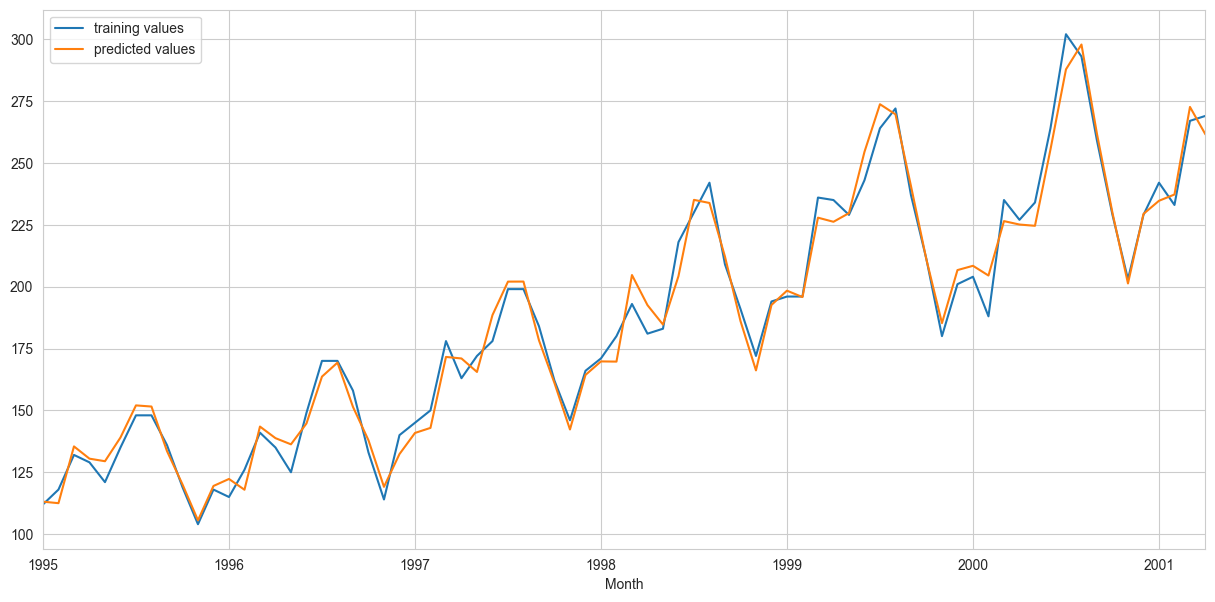

In [76]:
# forecasting on training data 
plt.figure(figsize=(15,7))
TRAIN.Passengers.plot(label='training values')
HoltWintModel.predict(start=0).plot(label='predicted values')
plt.legend()
plt.show()

In [85]:
print(f'TRAINING RMSE : {round(RMSE(TRAIN.Passengers,HoltWintModel.predict(start=0))*100,4)} %')

TRAINING RMSE : 4150.0264 %


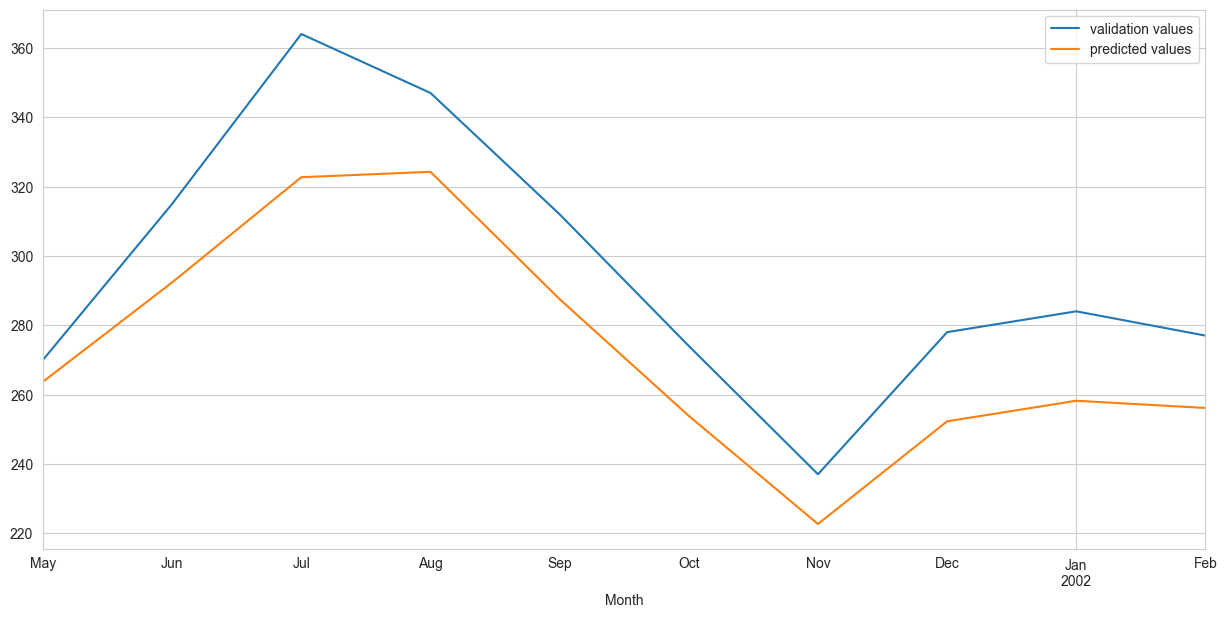

In [78]:
# forecasting on validation data 
plt.figure(figsize=(15,7))
VALID.Passengers.plot(label='validation values')
HoltWintModel.forecast(10).plot(label='predicted values')
plt.legend()
plt.show()

In [81]:
print(f'VALIDATION RMSE : {round(RMSE(VALID.Passengers,HoltWintModel.forecast(10))*100,4)} %')

VALIDATION RMSE : 57515.5287 %


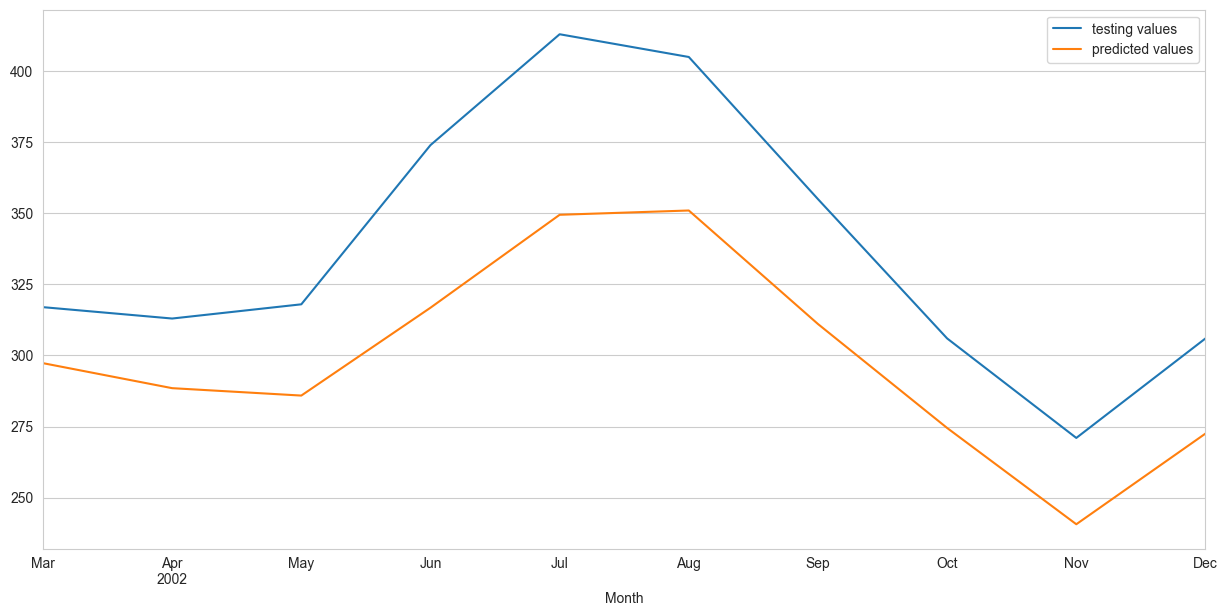

In [79]:
# forecasting on testing data 
plt.figure(figsize=(15,7))
TEST.Passengers.plot(label='testing values')
HoltWintModel.forecast(20)[10:].plot(label='predicted values')
plt.legend()
plt.show()

In [83]:
print(f'TESTING RMSE : {round(RMSE(TEST.Passengers,HoltWintModel.forecast(20)[10:])*100,4)} %')

TESTING RMSE : 172030.1001 %


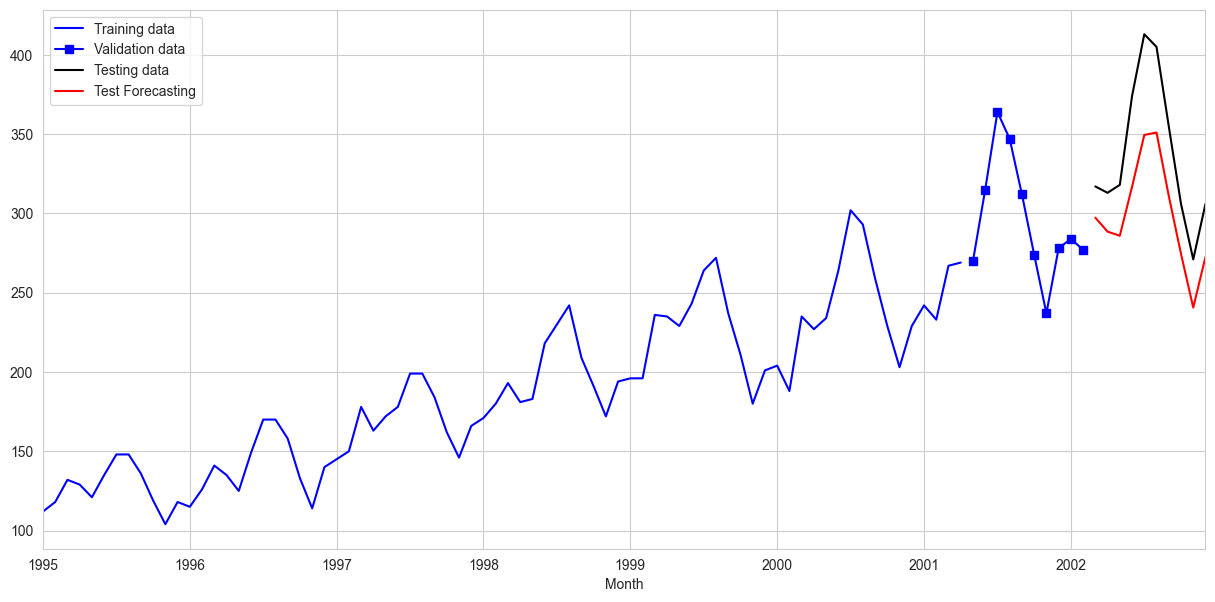

In [92]:
plt.figure(figsize=(15,7))
TRAIN.Passengers.plot(color='blue',label='Training data')
VALID.Passengers.plot(style='bs-',label='Validation data')
TEST.Passengers.plot(color='black',label='Testing data')
HoltWintModel.forecast(20)[10:].plot(color='red',
                                     label='Test Forecasting')
plt.legend()
plt.show()

In [86]:
pd.DataFrame([['TRAINING',4150.0264],
              ['VALIDATION',57515.5287],
              ['TESTING',172030.1]],columns=['HOLT WINTER','% RMSE'])

,HOLT WINTER,% RMSE
0,TRAINING,4150.0264
1,VALIDATION,57515.5287
2,TESTING,172030.1000
